In [1]:
!nvidia-smi

Tue Dec 31 06:12:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install patchify

In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns

(6310, 6911)

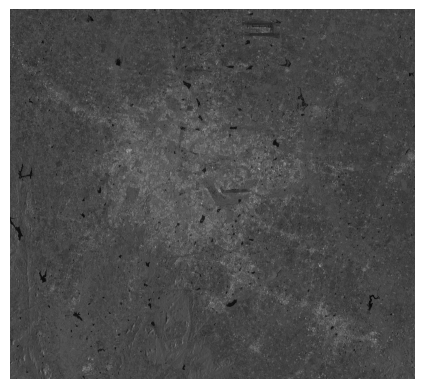

In [4]:
image = cv2.imread('/kaggle/input/2022-data/KAT_S1_median_VV_2022_Coregd_Despkl.tif',-1)
# image = cv2.imread(image_path,-1)
plt.imshow(image, 'gray')
plt.axis('off')
image.shape

(6310, 6911)

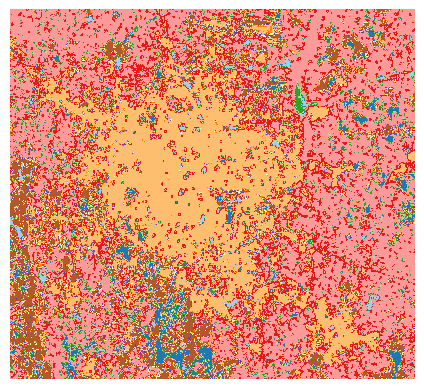

In [5]:
mask = cv2.imread('/kaggle/input/2022-data/ESRI_KAT_ROI_2022_Coreg.tif',-1)
plt.imshow(mask,'Paired')
plt.axis('off')
mask.shape

In [6]:
image_patch_size = 128

In [8]:
if image is not None:
    print(image.shape)

    size_x = (image.shape[1] // image_patch_size) * image_patch_size
    size_y = (image.shape[0] // image_patch_size) * image_patch_size
    print(f"{image.shape} --- {size_x} - {size_y}")
    image = Image.fromarray(image).crop((0, 0, size_x, size_y))
    print(f"({image.size[0]},  {image.size[1]})")
    image = np.array(image)

    patched_images = patchify(image, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_images.shape)

    # Flatten patched_images array to 2D
    patched_images_flattened = patched_images.reshape(-1, patched_images.shape[2], patched_images.shape[3])
    print(patched_images_flattened.shape)

(6272, 6784)
(6272, 6784) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [9]:
if mask is not None:
    print(mask.shape)

    size_x = (mask.shape[1] // image_patch_size) * image_patch_size
    size_y = (mask.shape[0] // image_patch_size) * image_patch_size
    print(f"{mask.shape} --- {size_x} - {size_y}")
    mask = Image.fromarray(mask).crop((0, 0, size_x, size_y))
    print(f"({mask.size[0]},  {mask.size[1]})")
    mask = np.array(mask)

    patched_masks = patchify(mask, (image_patch_size, image_patch_size), step=image_patch_size)
    print(patched_masks.shape)

    # Flatten patched_masks array to 2D
    patched_masks_flattened = patched_masks.reshape(-1, patched_masks.shape[2], patched_masks.shape[3])
    print(patched_masks_flattened.shape)

(6310, 6911)
(6310, 6911) --- 6784 - 6272
(6784,  6272)
(49, 53, 128, 128)
(2597, 128, 128)


In [10]:
image_dataset = np.array(patched_images_flattened)
mask_dataset = np.array(patched_masks_flattened)

(-0.5, 127.5, 127.5, -0.5)

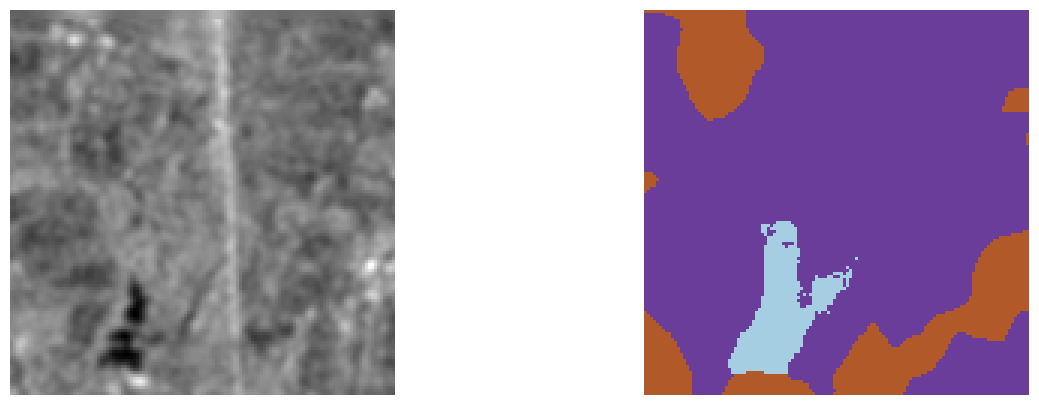

In [12]:
index= 20
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image_dataset[index], cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.axis('off')

In [13]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        3: 1,  # Flooded Vegetation becomes Water
        6: 4,  # Bare Ground becomes Crops
        7: 4,  # Snow/Ice becomes Crops
        8: 4,  # Clouds becomes Crops
        9: 4   # Rangeland becomes Crops
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Water
        4: 1,  # Cropland
        2: 3,  # Treecover
        5: 2,  # Builtup
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [14]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (2597, 128, 128)


In [15]:
before_Water = len(np.where(mask_dataset.flatten()==1)[0])
before_Trees =   len(np.where(mask_dataset.flatten()==2)[0])
before_Flooded_Vegetation =   len(np.where(mask_dataset.flatten()==3)[0])
before_Crops =   len(np.where(mask_dataset.flatten()==4)[0])
before_BuiltArea =   len(np.where(mask_dataset.flatten()==5)[0])
before_BareGround =   len(np.where(mask_dataset.flatten()==6)[0])
before_SnowIce =   len(np.where(mask_dataset.flatten()==7)[0])
before_Clouds =   len(np.where(mask_dataset.flatten()==8)[0])
before_Rangeland =   len(np.where(mask_dataset.flatten()==9)[0])

after_Water =   len(np.where(labels_dataset.flatten()==0)[0])
after_Trees =   len(np.where(labels_dataset.flatten()==3)[0])
after_Crops =   len(np.where(labels_dataset.flatten()==1)[0])
after_BuiltArea =   len(np.where(labels_dataset.flatten()==2)[0])

assert (before_Water+before_Flooded_Vegetation) == after_Water, "Water does not match"
assert (before_Crops+before_BareGround+before_SnowIce+before_Clouds+before_Rangeland) == after_Crops, "Crops does not match"
assert before_Trees == after_Trees, "Trees does not match"
assert before_BuiltArea == after_BuiltArea, "BuiltArea does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Trees/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Crops/(labels_dataset.flatten().shape[0]), 3),
                        ' BuiltArea = ', np.round(after_BuiltArea/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [16]:
print(labels_dataset[0].shape)
print(image_dataset[0].shape)

(128, 128)
(128, 128)


In [17]:
n_classes = 4

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

def dense_block(x, blocks, growth_rate=12):
    """Efficient dense block with reduced parameters"""
    for i in range(blocks):
        x1 = BatchNormalization()(x)
        x1 = Activation('relu')(x1)
        x1 = Conv2D(growth_rate, 3, padding='same', use_bias=False)(x1)
        x = Concatenate()([x, x1])
    return x

def transition_down(x):
    """Transition down with 1x1 convolution to reduce parameters"""
    n_channels = x.shape[-1]
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_channels // 2, 1, use_bias=False)(x)
    x = MaxPooling2D(2)(x)
    return x

def transition_up(x, skip_connection):
    """Transition up with simple upsampling"""
    n_channels = x.shape[-1]
    x = UpSampling2D(2)(x)
    x = Concatenate()([x, skip_connection])
    return x

def build_efficient_fcdensenet(input_shape=(128, 128, 1), n_classes=4):
    """Efficient FC-DenseNet with reduced parameters"""
    inputs = Input(input_shape)

    # Initial convolution
    x = Conv2D(48, 3, padding='same', use_bias=False)(inputs)

    # Downsampling path
    skip_connections = []

    # Using smaller number of blocks and growth rate for efficiency
    down_blocks = [4, 4, 4, 4]

    for n_blocks in down_blocks:
        x = dense_block(x, n_blocks)
        skip_connections.append(x)
        x = transition_down(x)

    # Bottleneck
    x = dense_block(x, 4)

    # Upsampling path
    for n_blocks, skip in zip(down_blocks[::-1], skip_connections[::-1]):
        x = transition_up(x, skip)
        x = dense_block(x, n_blocks)

    # Final convolution
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
X = image_dataset.reshape(-1, 128, 128, 1)
y = tf.keras.utils.to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_efficient_fcdensenet()

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    # verbose=12,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    # class_weight=class_weights,
                    callbacks=[callback])

Epoch 1/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.7483 - loss: 0.6576 - val_accuracy: 0.5939 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 2/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 107s 821ms/step - accuracy: 0.7988 - loss: 0.5090 - val_accuracy: 0.7665 - val_loss: 0.6258 - learning_rate: 0.0010
Epoch 3/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 105s 809ms/step - accuracy: 0.8028 - loss: 0.4968 - val_accuracy: 0.7998 - val_loss: 0.5048 - learning_rate: 0.0010
Epoch 4/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 105s 807ms/step - accuracy: 0.8200 - loss: 0.4541 - val_accuracy: 0.8020 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 5/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 105s 812ms/step - accuracy: 0.8230 - loss: 0.4472 - val_accuracy: 0.8208 - val_loss: 0.4583 - learning_rate: 0.0010
Epoch 6/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 105s 810ms/step - accuracy: 0.8160 - loss: 0.4523 - val_accuracy: 0.8031 - val_loss: 0.4860 - learning_rate: 0.0010
Epoch 7/40
130/130 ━━━━━━━━━━━━━━━━━━━━ 105s 811ms/step - accuracy:

In [21]:
model.save('fc_densenet_model.keras')

In [19]:
code_label ={'Water':0, 'Bareland':1, 'Builtup':2, 'Treecover':3}

In [20]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Trees =   len(np.where(flat_pixels==code_label['Treecover'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Trees = ', np.round(after_Trees/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' BuiltArea = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [21]:
def convert_to_rgb(masks):
  colour_dict={
    code_label['Water']:[0, 100, 200], #blue
    code_label['Bareland']:[240, 150, 255], #pink
    code_label['Builtup']:[250, 0, 0],  #red
    code_label['Treecover']:[0, 100, 0] #green
  }
  try:
    return np.array(list(map(lambda x : colour_dict[x], masks)))
  except:
    return np.array(list(map(lambda x : convert_to_rgb(x), masks)))

In [24]:
def unpatchify(patches, output_shape):
    if len(patches.shape) >3:
        num_patches, patch_height, patch_width, num_channel = patches.shape
    else:
        num_patches, patch_height, patch_width = patches.shape
        num_channel =1
    output_height, output_width = output_shape

    # Compute the number of patches along the height and width of the output image
    num_patches_h = output_height // patch_height
    num_patches_w = output_width // patch_width

    # Reshape patches into a grid
    patches_grid = patches.reshape(num_patches_h, num_patches_w, patch_height, patch_width,num_channel )

    # Concatenate patches along the height axis
    image_rows = [np.concatenate(patches_grid[i], axis=1) for i in range(num_patches_h)]

    # Concatenate rows along the width axis to reconstruct the image
    reconstructed_image = np.concatenate(image_rows, axis=0)

    return reconstructed_image

In [25]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [26]:
full_map_predictions = model.predict(image_dataset)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

82/82 ━━━━━━━━━━━━━━━━━━━━ 65s 405ms/step
(2597, 128, 128, 4)


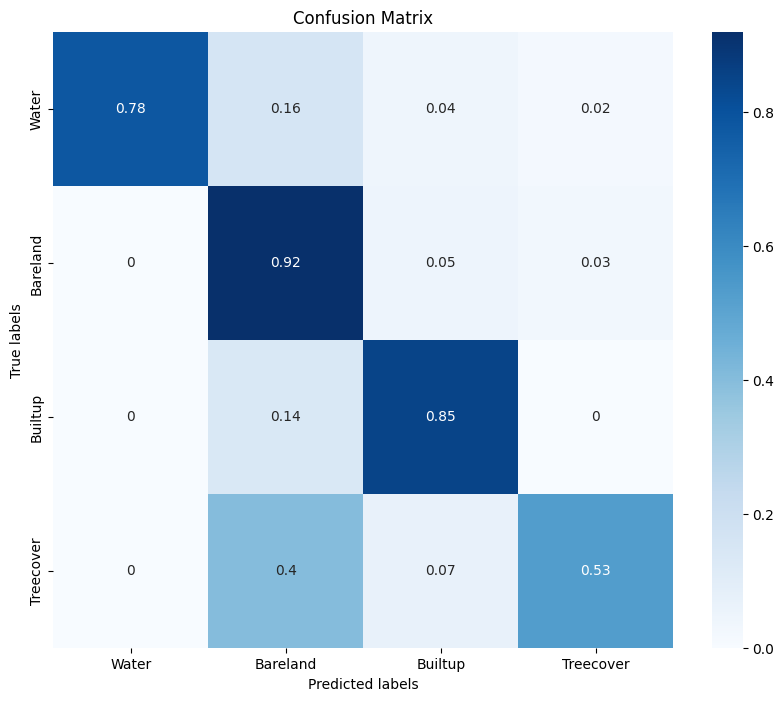

In [27]:
conf_matrix=confusion_matrix(labels_dataset.flatten(), full_map_reshape)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = np.round(conf_matrix, decimals=2)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=list(code_label.keys()), yticklabels=list(code_label.keys()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
report=classification_report(labels_dataset.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Water,0.857090,0.778598,0.815961,9.218360e+05
Bareland,0.850752,0.921225,0.884587,2.229441e+07
Builtup,0.914300,0.851936,0.882017,1.655157e+07
Treecover,0.685375,0.529299,0.597309,2.781426e+06
accuracy,0.865562,0.865562,0.865562,8.655617e-01
macro avg,0.826879,0.770265,0.794969,4.254925e+07
weighted avg,0.864799,0.865562,0.863321,4.254925e+07


In [29]:
pd.DataFrame.from_dict( compute_class_wise_iou(labels_dataset.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Water,0.689133
Bareland,0.793058
Builtup,0.788936
Treecover,0.425831
mean_iou,0.674240
weighted_iou,0.765197


In [31]:
print('Full Map Predictions : ')
count_class(full_map_reshape, code_label)
print('Full map true labels : ')
count_class(labels_dataset.flatten(), code_label)

Full Map Predictions : 
 Water =  0.02  Trees =  0.05  Bareland =  0.567  BuiltArea =  0.362
Full map true labels : 
 Water =  0.022  Trees =  0.065  Bareland =  0.524  BuiltArea =  0.389


In [32]:
full_map_pred_colour=convert_to_rgb(np.argmax(full_map_predictions, axis=-1))
full_map_test_colour=convert_to_rgb(labels_dataset)

In [33]:
print(full_map_pred_colour.shape)
print(full_map_test_colour.shape)
print(image_dataset.shape)

(2597, 128, 128, 3)
(2597, 128, 128, 3)
(2597, 128, 128)


Original image shape: (6272, 6784)
Number of patches: height=49, width=53
Reconstruction dimensions: (6272, 6784)


(-0.5, 6783.5, 6271.5, -0.5)

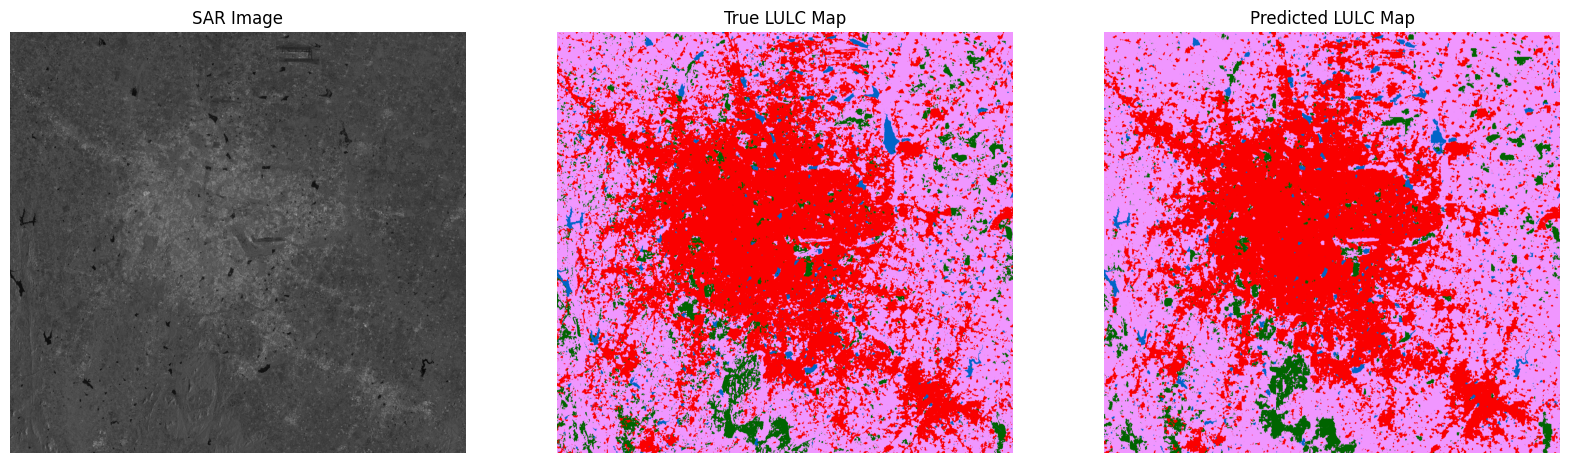

In [35]:
# Calculate correct dimensions
patch_size = 128
h, w = image.shape
n_h = h // patch_size
n_w = w // patch_size
reconstructed_height = n_h * patch_size
reconstructed_width = n_w * patch_size

print(f"Original image shape: {image.shape}")
print(f"Number of patches: height={n_h}, width={n_w}")
print(f"Reconstruction dimensions: ({reconstructed_height}, {reconstructed_width})")

plt.figure(figsize=(20, 25))

# Use the calculated dimensions
reconstructed_image = unpatchify(image_dataset, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 1)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('SAR Image')
plt.axis('off')

reconstructed_image = unpatchify(full_map_test_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_image)
plt.title('True LULC Map')
plt.axis('off')

reconstructed_image = unpatchify(full_map_pred_colour, (reconstructed_height, reconstructed_width))
plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title('Predicted LULC Map')
plt.axis('off')

In [36]:
per_sample_accuracy=[]
full_map_pred_argmax = np.argmax(full_map_predictions, axis=-1)
for i in range(full_map_pred_argmax.shape[0]):
    per_sample_accuracy.append(np.mean(full_map_pred_argmax[i].flatten() == labels_dataset[i].flatten()))


In [37]:
lower10mark = np.percentile(per_sample_accuracy, 10)
upper10mark = np.percentile(per_sample_accuracy, 90)

In [38]:
lower10_y_pred=[]
upper10_y_pred=[]
lower10_y_test=[]
upper10_y_test=[]
lower10_x_test=[]
upper10_x_test=[]
for i in range(len(per_sample_accuracy)):
    if(per_sample_accuracy[i]<=lower10mark):
        lower10_y_pred.append(full_map_pred_colour[i])
        lower10_y_test.append(full_map_test_colour[i])
        lower10_x_test.append(labels_dataset[i])
    elif(per_sample_accuracy[i]>=upper10mark):
        upper10_y_pred.append(full_map_pred_colour[i])
        upper10_y_test.append(full_map_test_colour[i])
        upper10_x_test.append(labels_dataset[i])

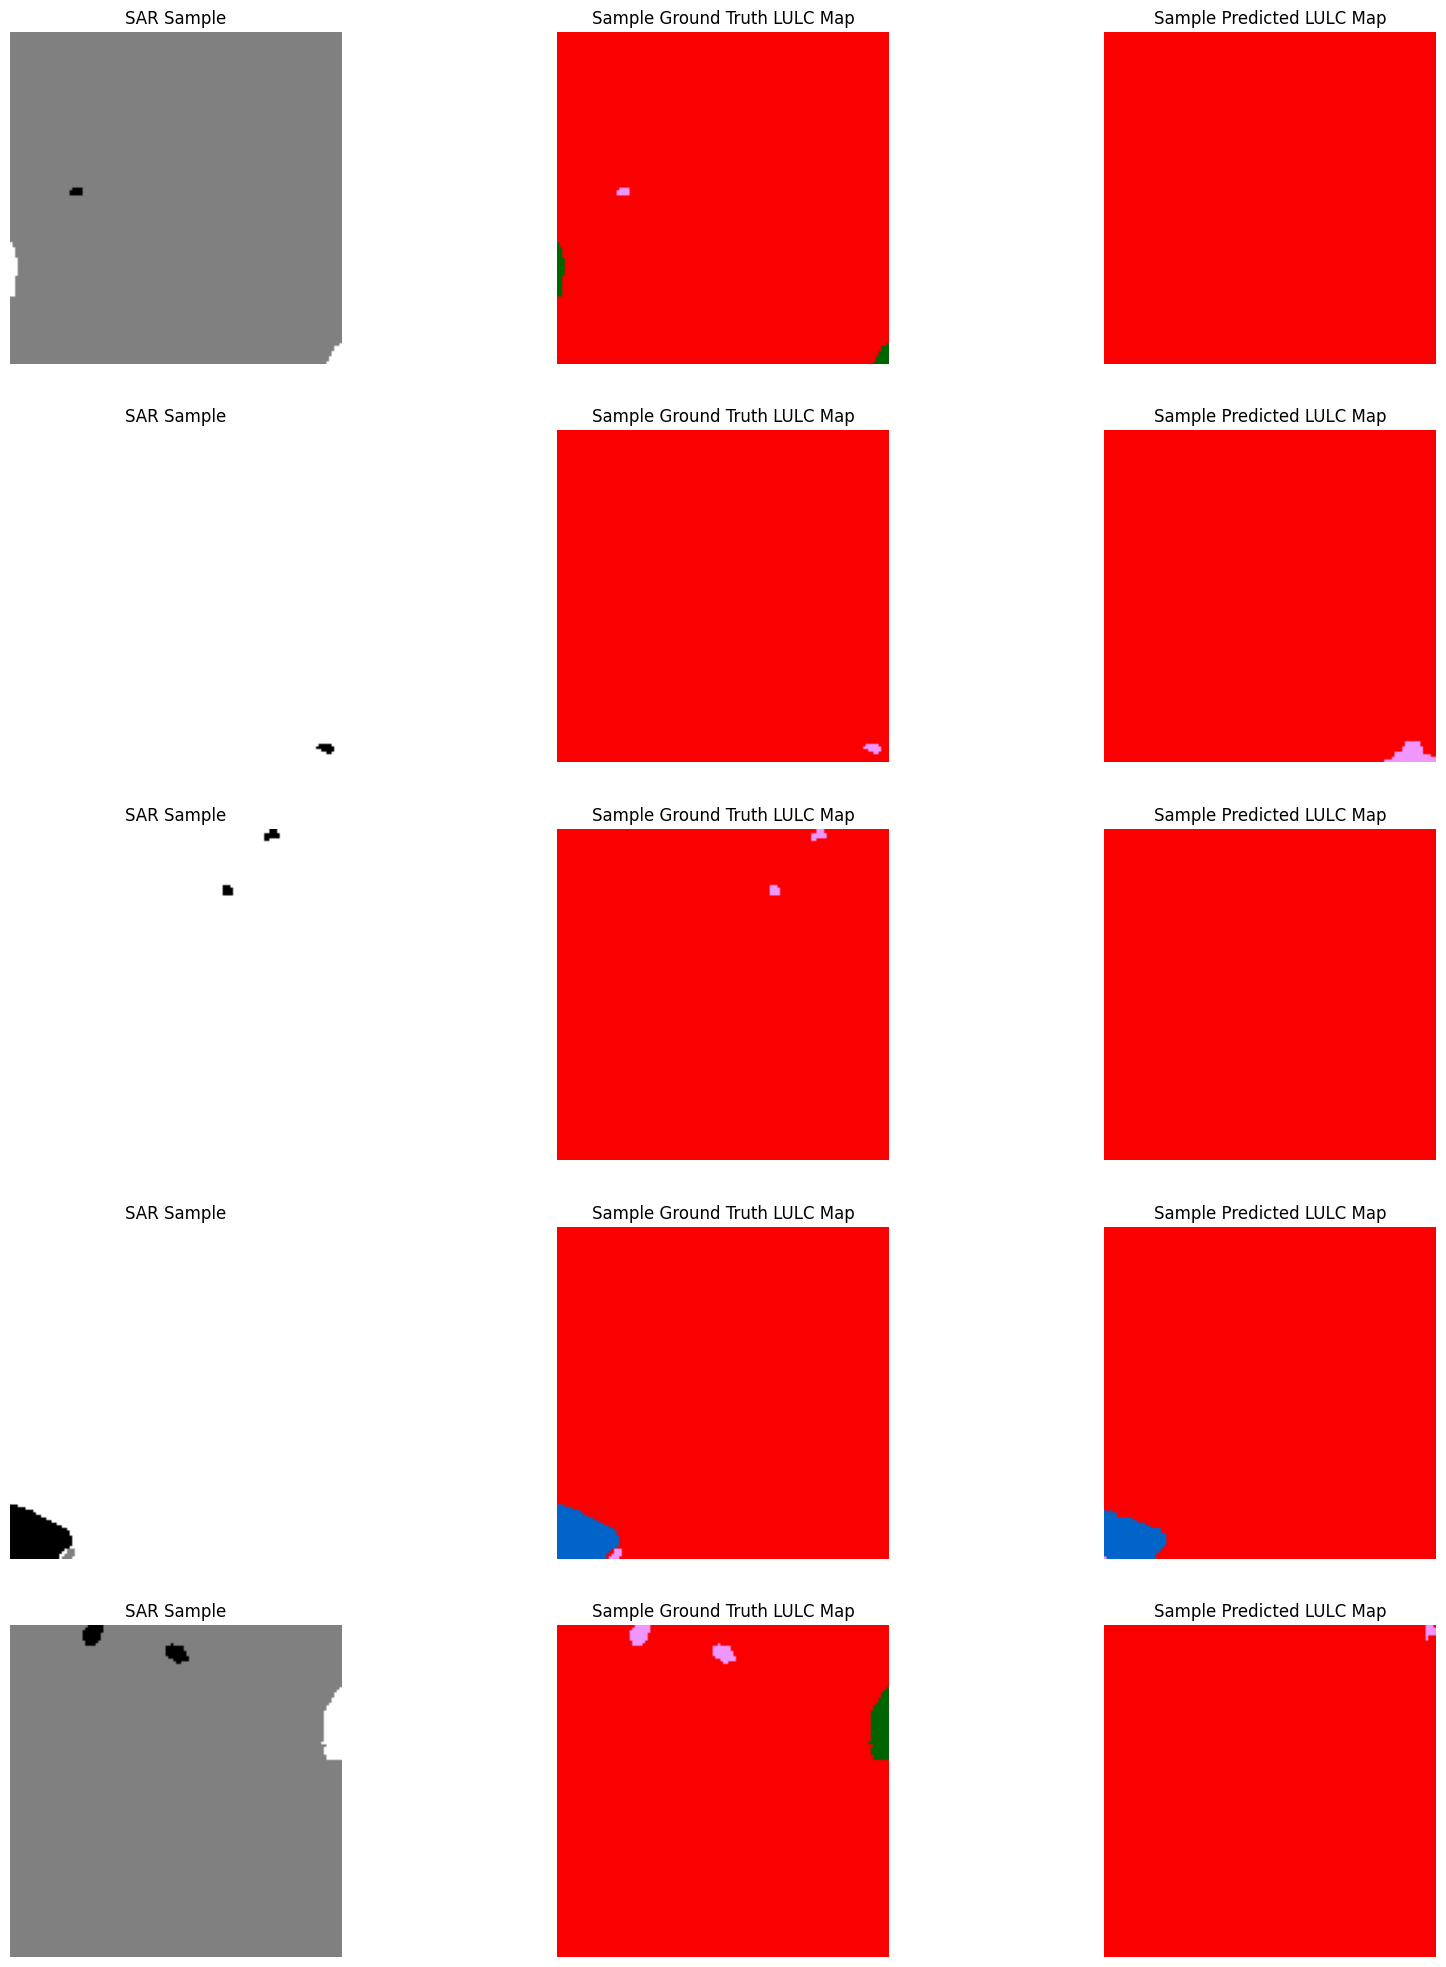

In [39]:
n_images=5
sample_index = np.random.choice(len(upper10_y_pred), n_images)
plt.figure(figsize=(20, 10*n_images/2))
for j,i in enumerate(sample_index):
    pred= upper10_y_pred[i]
    true= upper10_y_test[i]
    sar= upper10_x_test[i]
    plt.subplot(n_images, 3,(j*3)+1)
    plt.imshow(sar,cmap = 'gray')
    plt.title('SAR Sample')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+2)
    plt.imshow(true)
    plt.title('Sample Ground Truth LULC Map')
    plt.axis('off')
    plt.subplot(n_images, 3,(j*3)+3)
    plt.imshow(pred)
    plt.title('Sample Predicted LULC Map')
    plt.axis('off')